# MAGMA experimnetations

## Artificial data : Different HP

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import warnings

plt.style.use("bmh")
sys.path.append("../src/")
warnings.filterwarnings("ignore")

from kernels import ExponentiatedQuadraticKernel, GaussianKernel
from MAGMA import MAGMA

### Exponentied Quadratic Kernel

In [3]:
N = 100
M = 5

t0 = 0
tN = 10 + 1e-3

common_T = np.linspace(t0, tN, N)
print(common_T.shape)

(100,)


In [4]:
a = np.random.uniform(-2, 2)
b = np.random.uniform(0, 10)

m0 = a * common_T + b
m0_function = lambda t : a * t + b
print(m0.shape)

(100,)


In [5]:
theta0 = np.array([np.random.uniform(1, np.exp(5)), np.random.uniform(1, np.exp(2))])
print(theta0)

[59.37265651  6.2286937 ]


In [6]:
K_theta0 = ExponentiatedQuadraticKernel.compute_all(theta0, common_T)
print(K_theta0.shape)

(100, 100)


In [7]:
mu0 = np.random.multivariate_normal(m0, K_theta0)
print(mu0.shape)

(100,)


In [9]:
Theta = np.array([np.random.uniform(1, np.exp(5), size=M), np.random.uniform(1, np.exp(2), size=M)]).T
Sigma = np.random.uniform(0, 1, size=M)

print(Theta)
print(Sigma)

[[ 55.84061947   6.51797854]
 [121.95338144   4.23767337]
 [ 33.36484153   6.35250492]
 [ 35.1572153    3.64221833]
 [ 15.67726111   5.66994818]]
[0.25704191 0.77425165 0.77326298 0.78691345 0.52066191]


In [10]:
Y = np.zeros((M, N))
for i in range(M):
    C_Theta = ExponentiatedQuadraticKernel.compute_all(Theta[i], common_T)
    Psi_Theta_Sigma = C_Theta + Sigma[i] * np.identity(N)
    Yi = np.random.multivariate_normal(mu0, Psi_Theta_Sigma)
    Y[i] = Yi
print(Y.shape)

(5, 100)


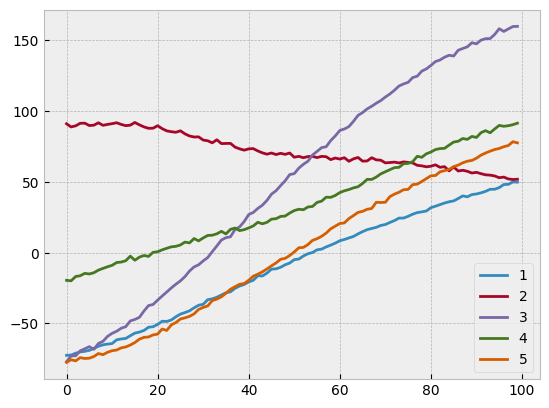

In [41]:
for i in range(M):
    plt.plot(Y[i], label=f"{i + 1}")
plt.legend()
plt.show()

In [15]:
model = MAGMA(
    T=None,
    Y=Y,
    common_T=common_T,
    m0=m0, 
    m0_function=m0_function,
    theta0=np.array([np.random.uniform(1, np.exp(5)), np.random.uniform(1, np.exp(2))]), 
    Theta=np.array([np.random.uniform(1, np.exp(5), size=M), np.random.uniform(1, np.exp(2), size=M)]).T, 
    Sigma=np.random.uniform(0, 1, size=M),
    common_hp_flag=False,
    save_history_flag=True,
    scipy_optimize_display=False,
    kernel_k=ExponentiatedQuadraticKernel,
    kernel_c=ExponentiatedQuadraticKernel,
)

In [16]:
model.fit(max_iterations=100, eps=1e-4)

MAGMA Training:  29%|██▉       | 29/100 [38:15<1:33:40, 79.16s/it]


In [17]:
history = model.history
len(history)

31

In [18]:
LL_theta0 = []
LL_Theta_Sigma = []

for epoch_history in history[1:]:
    LL_theta0.append(epoch_history["LL_theta0"])
    LL_Theta_Sigma.append(epoch_history["LL_Theta_Sigma"])

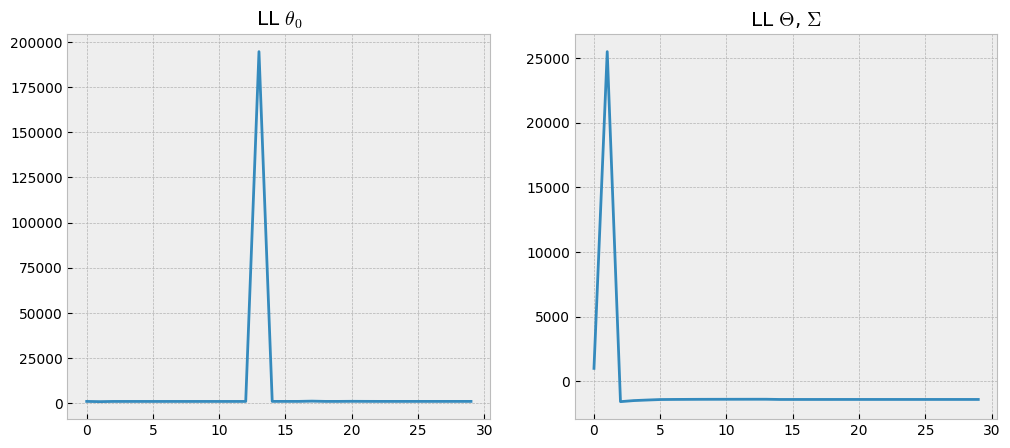

In [40]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(LL_theta0)
plt.title("LL $\\theta_0$")
plt.subplot(1, 2, 2)
plt.plot(LL_Theta_Sigma)
plt.title("LL $\Theta$, $\Sigma$")
plt.show()

In [30]:
Sigma = []
for epoch_history in history:
    Sigma.append(epoch_history["Sigma"])
Sigma = np.array(Sigma)
print(model.Sigma)

[ 6.83998810e-01  1.32578610e+00 -2.57613362e+02  1.67543559e+00
 -8.18666946e-02]


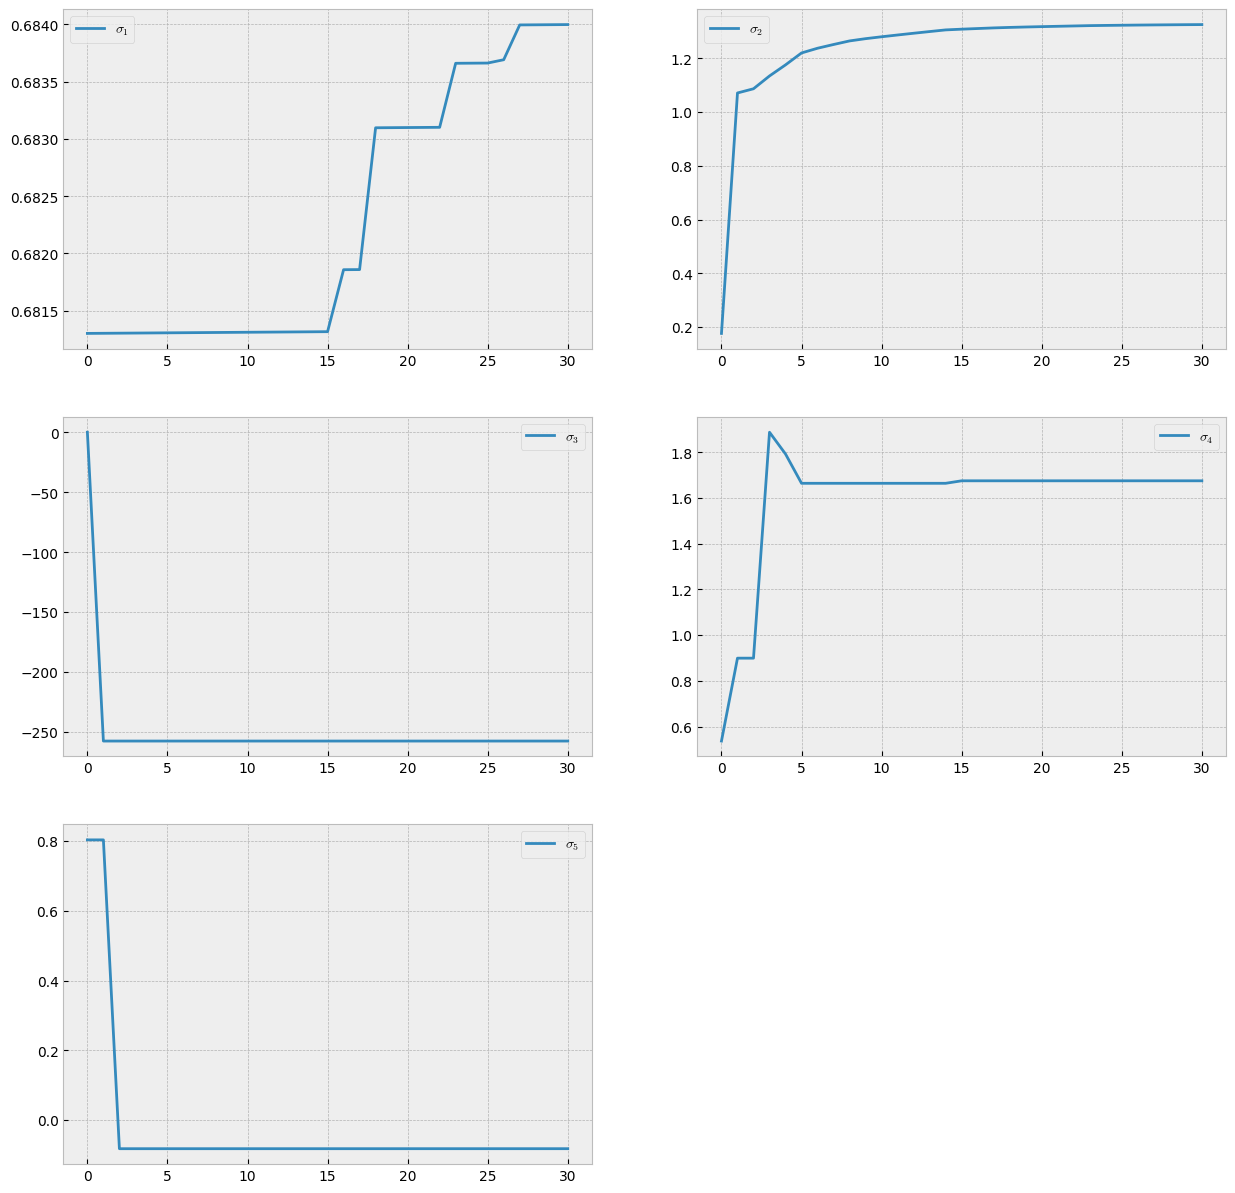

In [45]:
plt.figure(figsize=(15, int(np.ceil(M/2)) * 5))
for i in range(1, M + 1):
    plt.subplot(int(np.ceil(M/2)), 2, i)
    plt.plot(Sigma[:, i - 1], label=f"$\sigma_{i}$")
    plt.legend()
plt.show()

In [27]:
m0_estim_norms = []
for epoch_history in history[1:]:
    m0_estim_norms.append(np.linalg.norm(epoch_history["m0"]))

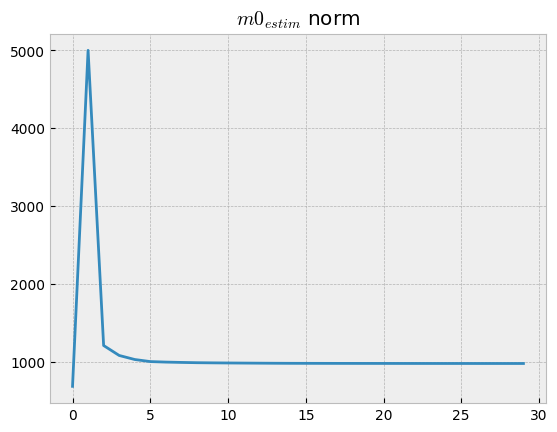

In [47]:
plt.plot(m0_estim_norms)
plt.title("$m0_{estim}$ norm")
plt.show()

In [48]:
theta0 = []
for epoch_history in history:
    theta0.append(epoch_history["theta0"])
theta0 = np.array(theta0)
print(model.theta0)

[59.30562709  2.26707365]


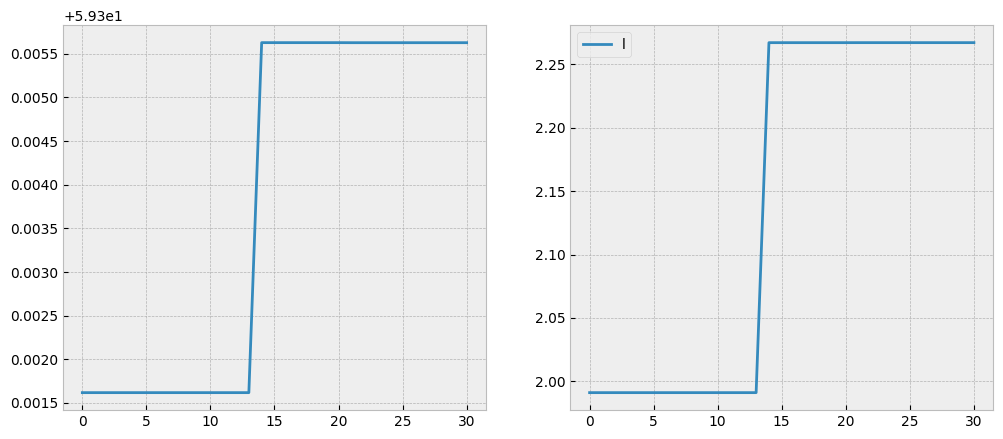

In [49]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(theta0[:, 0], label="v")
plt.subplot(1, 2, 2)
plt.plot(theta0[:, 1], label="l")
plt.legend()
plt.show()

In [51]:
Theta = []
for epoch_history in history:
    Theta.append(epoch_history["Theta"])
Theta = np.array(Theta)
print(Theta.shape)
print(model.Theta)

(31, 5, 2)
[[ 14.3105298    1.49211084]
 [  9.55977303   7.5225034 ]
 [ 84.87947348 265.02753186]
 [100.72957538   5.20945137]
 [132.52473456   2.20114009]]


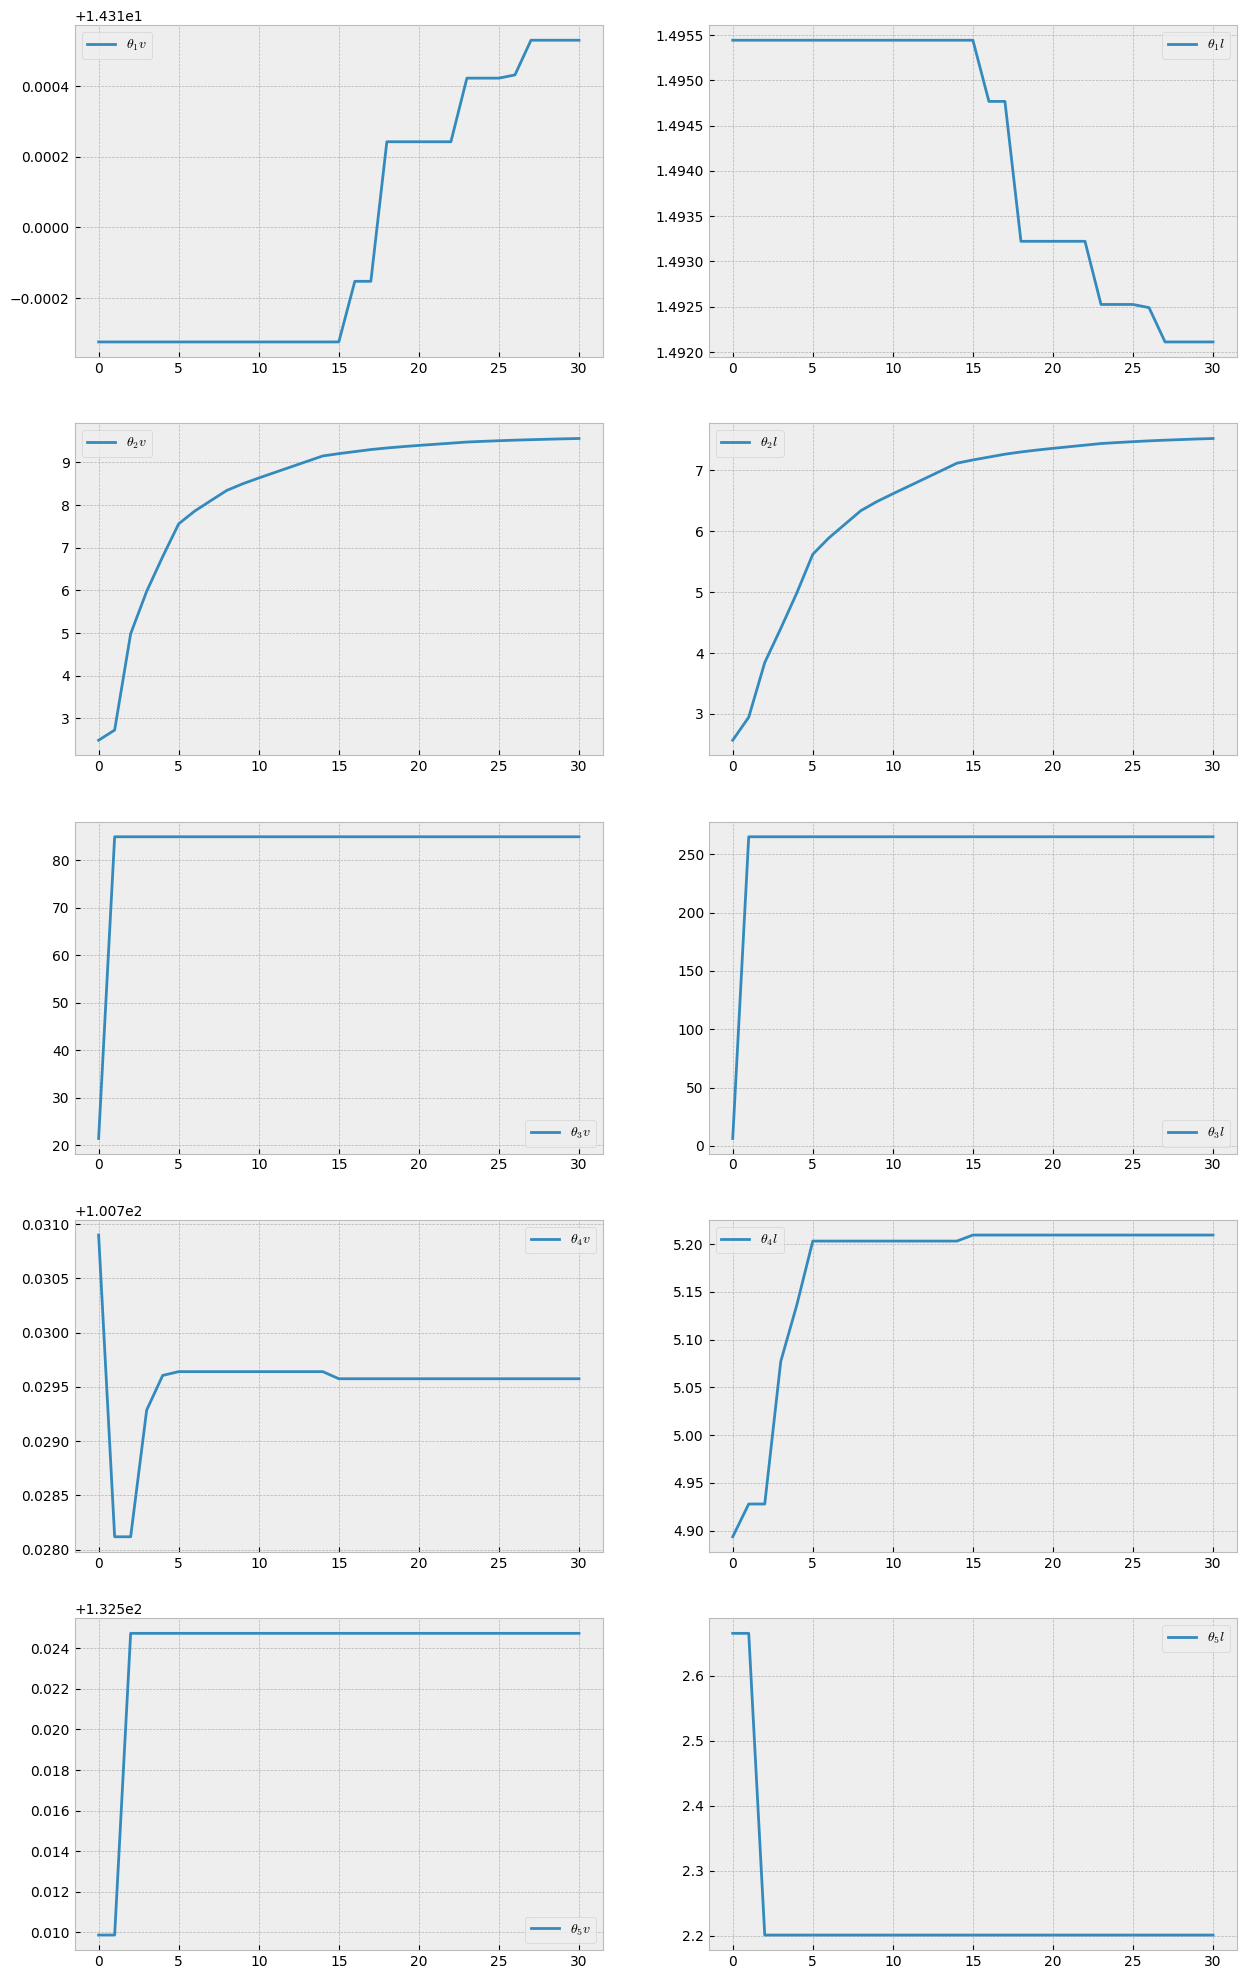

In [56]:
plt.figure(figsize=(15, M * 5))
cpt = 0
for i in range(1, M + 1):
    cpt += 1
    plt.subplot(M, 2, cpt)
    plt.plot(Theta[:, i - 1, 0], label=f"$\\theta_{i} v$")
    plt.legend()
    cpt += 1
    plt.subplot(M, 2, cpt)
    plt.plot(Theta[:, i - 1, 1], label=f"$\\theta_{i} l$")
    plt.legend()
plt.show()